Assume we have a mask shape such as circle, and we want to fit as many rectangles in it

In [108]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from dataclasses import dataclass

from uuid import uuid4

from math import sin, cos
import numpy as np
from copy import deepcopy
from typing import List


In [132]:
def get_text_with_height(text, font_size, silent_mode=True):
    fig, ax = plt.subplots()
    if silent_mode:
        plt.close(fig)  # Avoid displaying the plot

    plt_text = ax.text(
        0, 0, text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=font_size,
        visible=True,
    )
    r = fig.canvas.get_renderer()
    bb = plt_text.get_window_extent(renderer=r).transformed(fig.gca().transData.inverted())
    if silent_mode:
        fig.clear()
    return bb.width, bb.height


def get_text_with_height_(text, font_size, silent_mode=None):
    scale = 0.0051
    width = scale * font_size * len(text)
    height = scale * font_size
    return width, height

4.989172640382318 0.8922001471670346 5.591988138787275
16.32 1.02 16.0


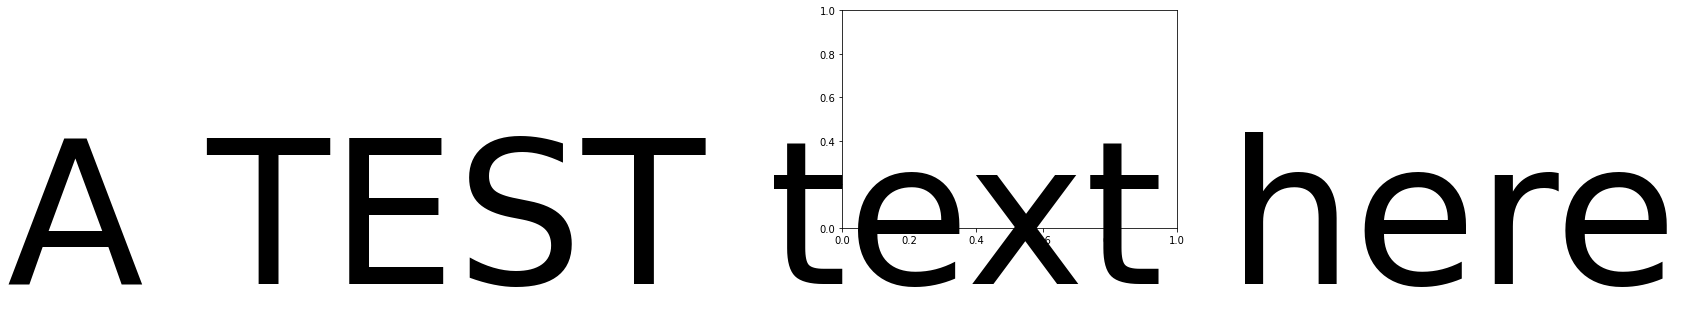

In [133]:
width, height = get_text_with_height('A TEST text here', font_size=200, silent_mode=False)
print(width, height, width/height)
width, height = get_text_with_height_('A TEST text here', font_size=200, silent_mode=True)
print(width, height, width/height)

# get_text_with_height = get_text_with_height_

In [134]:
@dataclass(unsafe_hash=False)
class Pos:
    x: float
    y: float
        
    def __hash__(self):
        return hash((self.x, self.y))


@dataclass
class Circle:
    c: Pos
    r: float
    layer_number: int = 0

        
@dataclass 
class Rectangle:
    c: Pos  # center of the rectangle
    width: float
    height: float
    layer_number: int = 0
    label: str= None
    uuid: str= None
        
    def __post_init__(self):
        if self.uuid is None:
            self.uuid = str(uuid4())
        if self.width < 0:
            self.width = -self.width
        if self.height < 0:
            self.height = -self.height
            
            
@dataclass
class TextBoxItem:
    text: str
    font_size: float
    c: Pos = None
    width: float = None
    height: float = None
    layer_number: int = None
    bbox_uuid: str = None
    bbox: Rectangle = None
    
    def __post_init__(self):
        self.font_size = round(self.font_size, 2)

        if self.width is None or self.height is None:
            width, height = get_text_with_height(self.text, self.font_size)
        if self.width is None:
            self.width = round(width, 3)
        if self.height is None:
            self.height = round(height, 3)


In [135]:
def find_bound(shapes):
    x_min = float('inf')
    x_max = float('-inf')
    y_min = float('inf')
    y_max = -float('inf')
    for shape in shapes:
        if type(shape) == Circle:
            x_min = min(x_min, shape.c.x - shape.r)
            x_max = max(x_max, shape.c.x + shape.r)
            y_min = min(y_min, shape.c.y - shape.r)
            y_max = max(y_max, shape.c.y + shape.r)
        if type(shape) == Rectangle or type(shape) == TextBoxItem:
            x_min = min(x_min, shape.c.x - shape.width / 2)
            x_max = max(x_max, shape.c.x + shape.width / 2)
            y_min = min(y_min, shape.c.y - shape.height / 2)
            y_max = max(y_max, shape.c.y + shape.height / 2)
    return x_min, x_max, y_min, y_max

In [136]:
def draw(shapes, text_font_scale):
    x_min, x_max, y_min, y_max = find_bound(shapes)

    fig, ax = plt.subplots(figsize=(x_max - x_min, y_max - y_min))
    ax.axis([x_min, x_max, y_min, y_max])
    
    color_list = list(mcolors.TABLEAU_COLORS)
    color_index = 0

    for shape in shapes:
        color_name = color_list[color_index]
        color_index = (color_index + 1) % len(color_list)

        if shape.layer_number is not None:
            color_name = color_list[shape.layer_number % len(color_list)]
        if type(shape) == Circle:
            circle = plt.Circle(
                (shape.c.x, shape.c.y),
                shape.r,
                fill=False,
                color=color_name,
            )
            ax.add_patch(circle)
        if type(shape) == Rectangle:
            c = shape.c
            hw = shape.width / 2
            hh = shape.height / 2
            ax.plot(
                [c.x - hw, c.x + hw, c.x + hw, c.x - hw, c.x - hw], 
                [c.y - hh, c.y - hh, c.y + hh, c.y + hh, c.y - hh],
                color=color_name,
            )
#             d = 0.1
#             ax.plot(
#                 [c.x - hw + d, c.x + hw - d, c.x + hw - d, c.x - hw + d, c.x - hw + d],
#                 [c.y - hh + d, c.y - hh + d, c.y + hh - d, c.y + hh - d, c.y - hh + d],
#                 color=color_name,
#             )
        if type(shape) == TextBoxItem:
            c = shape.c
            hw = shape.width / 2
            hh = shape.height / 2
            ax.text(
                c.x, c.y, shape.text,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=shape.font_size * text_font_scale,
                visible=True,
                color=color_name,
            )

In [137]:
def _is_point_in_rect(p: Pos, rect: Rectangle):
    x1 = rect.c.x - rect.width / 2
    x2 = rect.c.x + rect.width / 2
    y1 = rect.c.y - rect.height / 2
    y2 = rect.c.y + rect.height / 2
    if (p.x >= x1 and p.x <= x2 and p.y >= y1 and p.y <= y2):
        return True
    return False


def _does_line_bifurcate_rect(line: Rectangle, rect: Rectangle):
    if line.width != 0 and line.height != 0:
        raise Exception(f"Invalid line {line}")
    if line.width == 0:
        p1 = Pos(line.c.x, line.c.y - line.height / 2)
        p2 = Pos(line.c.x, line.c.y + line.height / 2)
        if (
            p1.y <= rect.c.y - rect.height / 2 
            and p2.y >= rect.c.y + rect.height / 2
            and p1.x >= rect.c.x - rect.width / 2 
            and p1.x <= rect.c.x + rect.width / 2
        ):
            return True
    if line.height == 0:
        p1 = Pos(line.c.x - line.width / 2, line.c.y)
        p2 = Pos(line.c.x + line.width / 2, line.c.y)
        if (
            p1.x <= rect.c.x - rect.width / 2 
            and p2.x >= rect.c.x + rect.width / 2
            and p1.y >= rect.c.y - rect.height / 2 
            and p1.y <= rect.c.y + rect.height / 2
        ):
            return True
    return False


def _get_rect_corners(r: Rectangle):
    return [
        Pos(r.c.x - r.width / 2, r.c.y - r.height / 2),
        Pos(r.c.x + r.width / 2, r.c.y - r.height / 2),
        Pos(r.c.x - r.width / 2, r.c.y + r.height / 2),
        Pos(r.c.x + r.width / 2, r.c.y + r.height / 2),
    ]


def _get_rect_lines(r: Rectangle):
    return[
        Rectangle(Pos(r.c.x - r.width / 2, r.c.y), 0, r.height),
        Rectangle(Pos(r.c.x + r.width / 2, r.c.y), 0, r.height),
        Rectangle(Pos(r.c.x, r.c.y - r.height / 2), r.width, 0),
        Rectangle(Pos(r.c.x, r.c.y + r.height / 2), r.width, 0),
    ]


def is_colliding(rect1: Rectangle, rect2: Rectangle):
    if rect1 is None or rect2 is None:
        return False
    rect1_points = _get_rect_corners(rect1)
    rect2_points = _get_rect_corners(rect2)
    if any([_is_point_in_rect(p, rect2) for p in rect1_points]):
        return True
    if any([_is_point_in_rect(p, rect1) for p in rect2_points]):
        return True
    if any(_does_line_bifurcate_rect(l, rect2) for l in _get_rect_lines(rect1) ): 
        return True
    if any(_does_line_bifurcate_rect(l, rect1) for l in _get_rect_lines(rect2) ): 
        return True
    return False

In [138]:
def _is_colliding_with_any(rect: Rectangle, rects: list):
    for r in rects:
        if is_colliding(r, rect):
            return True
    return False


def theta(r):
    a_prime_number = 173
    return (a_prime_number * r) ** 5


def _generate_xy_coords_in_circle(max_r, num_items):
    num_steps = 10 * num_items
    radius = max_r * np.sqrt(np.array(range(num_steps)) / num_steps)
    coords = [Pos(r * cos(theta(r)), r * sin(theta(r))) for r in radius]
    return coords


def fit_rectangles_in_circle(
    rects: List[Rectangle],
    radius: float,
    forbidden_coords: set=set(),
    layer_number: int=0
):
    rects = deepcopy(rects)
    rects.sort(key=lambda x: -x.height)
    search_space_coords = _generate_xy_coords_in_circle(radius, len(rects) )
    forbidden_coords = deepcopy(forbidden_coords)
    drawn_rects = []
    not_drawn_rects = []
    blocked_coords = set()
    for rect in rects:
        seen_coords = set()
        for i, xy in enumerate(search_space_coords):
            if xy in blocked_coords or xy in forbidden_coords:
                continue
            seen_coords.add(xy)
            rect.c = Pos(xy.x, xy.y)
            rect.layer_number = layer_number
            if not _is_colliding_with_any( rect, drawn_rects ):
                drawn_rects.append(rect)
                forbidden_coords.add(xy)
                # blocks those coordinate point inside the rect
                for xy in seen_coords:
                    if xy not in blocked_coords and _is_point_in_rect(xy, rect):
                        blocked_coords.add(xy)
                break
        if i == len(search_space_coords) - 1:
            not_drawn_rects.append(rect)

    return drawn_rects, not_drawn_rects, blocked_coords, forbidden_coords

In [145]:
def fit_text_items_in_circle(texts: List[TextBoxItem], radius):
    texts = deepcopy(texts)

    rectangles = []
    for t in texts:
        rect = Rectangle(c=None, width=t.width, height=t.height)
        t.bbox_id = rect.uuid
        rectangles.append(rect)

    not_drawn_items = rectangles
    drawn_rects = []
    forbidden_coords = set()
    blocked_coords = []
    layer_number = 1
    while not_drawn_items:
        drawn_rects_, not_drawn_items, blocked_coords_, forbidden_coords = fit_rectangles_in_circle(
            not_drawn_items, radius, forbidden_coords, layer_number
        )
        blocked_coords.extend(blocked_coords_)
        drawn_rects.extend(drawn_rects_)
#         print(f"Iteration #{layer_number}: len(drawn_rects)={len(drawn_rects)}, len(not_drawn_rects)={len(not_drawn_items)}")
        layer_number += 1
    
    rects_by_id = {r.uuid: r for r in drawn_rects}

    for text in texts:
#         print(f"rects_by_id[text.bbox_id]={rects_by_id[text.bbox_id]}")
        text.bbox = rects_by_id[text.bbox_id]
        text.layer_number = text.bbox.layer_number
        text.c = text.bbox.c
    return texts, drawn_rects

In [210]:
random.seed(1)
sentence = (
    "Lorem ipsum dolor sit amet, "
    "consectetur adipiscing elit, "
#     "sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."
#     "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."
)
fscale = 2
texts = [
    TextBoxItem(text=s.strip(), font_size=fscale * random.uniform(16, 72))
    for s in sentence.split()
]

In [211]:
max_r = 4
fitted_texts, drawn_rects = fit_text_items_in_circle(texts, max_r)

In [212]:
# fitted_texts

In [213]:
# rects_by_id

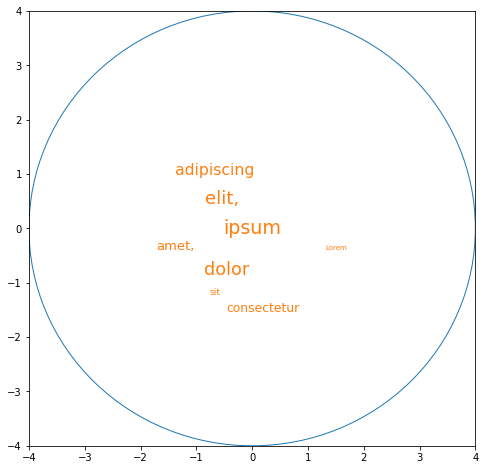

In [215]:
shapes = [Circle(Pos(0, 0), max_r, layer_number=0)]  +  fitted_texts # + drawn_rects

draw(shapes, text_font_scale=0.15)

# Tests

TextBoxItem(text='here', font_size=15, c=Pos(x=1, y=1), width=0.306, height=0.077, layer_number=2, bbox_uuid=None, bbox=None)

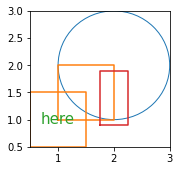

In [103]:
t = TextBoxItem(text='here', c=Pos(1, 1), font_size=15, layer_number=2)
draw([
    Circle(Pos(2,2), 1, layer_number=0),
    Rectangle(Pos(1,1), 1, 1, layer_number=1),
    Rectangle(Pos(1.5,1.5), 1, 1, layer_number=1),
    Rectangle(Pos(2,1.4), 0.5, 1, layer_number=203),
    t,
], text_font_scale=1)
t

In [105]:
def test_is_point_in_rect():
    rect = Rectangle(Pos(1, 1), 2, 2)
    test_points = [
        {'p': Pos(1, 1), 'res': True},
        {'p': Pos(4, 1), 'res': False},
    ]
    for p in test_points:
        assert _is_point_in_rect(p['p'], rect) == p['res']

test_is_point_in_rect()

def test_does_line_bifuricate_rect():
    line = Rectangle(Pos(0, 0), 0, 2)
    rect = Rectangle(Pos(0, 0), 2, 1)
    assert _does_line_bifurcate_rect(line, rect)

    line = Rectangle(Pos(0, 0), 2, 0)
    rect = Rectangle(Pos(0, 0), 1, 1)
    assert _does_line_bifurcate_rect(line, rect)

    line = Rectangle(Pos(0, 0), 1, 0)
    rect = Rectangle(Pos(0, 0), 2, 1)
    assert not _does_line_bifurcate_rect(line, rect)
    
test_does_line_bifuricate_rect()

def test_get_rect_lines():
    rect = Rectangle(Pos(0, 0), 1, 2)
#     print(_get_rect_lines(rect))
    pass


test_get_rect_lines()


def test_is_colliding():
    rect = Rectangle(Pos(1, 1), 2, 2)
    rects = [
        {'rect': Rectangle(Pos(1, 1), 1, 1), 'res': True},
        {'rect': Rectangle(Pos(1, 1), 3, 3), 'res': True},
        {'rect': Rectangle(Pos(2, 1), 1, 1), 'res': True},
        {'rect': Rectangle(Pos(1, 1), 3, 0.5), 'res': True},
        {'rect': Rectangle(Pos(1, 1), 0.5, 3), 'res': True},
        {'rect': Rectangle(Pos(4, 1), 1, 1), 'res': False},
    ]
    for r in rects:
        assert is_colliding(r['rect'], rect) == r['res'], f"{r} collision check with {rect}?"

test_is_colliding()

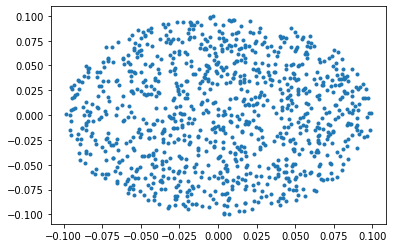

In [164]:
max_r = 0.1
num_items = 100
coords = _generate_xy_coords_in_circle(max_r, num_items)
fig, ax = plt.subplots()
ax.plot([p.x for p in coords], [p.y for p in coords], '.')

[Rectangle(c=None, width=3.220461882888657, height=2.449445608699771, layer_number=0, label=None, uuid='14789217-ccdc-449f-a4a6-dc8c747c921a'), Rectangle(c=None, width=0.16583952234565477, height=1.235456349028368, layer_number=0, label=None, uuid='e5a24a19-8f53-4a04-888e-5de6a71b24e4'), Rectangle(c=None, width=2.7304330377603536, height=3.0313345168317167, layer_number=0, label=None, uuid='45dbaccb-06a3-4d73-ae10-00c5cf7064f6'), Rectangle(c=None, width=2.555257925027182, height=2.56317055489747, layer_number=0, label=None, uuid='08dfd5d6-408d-4834-867f-b1878b7ad236')]
len(drawn_rects)=4


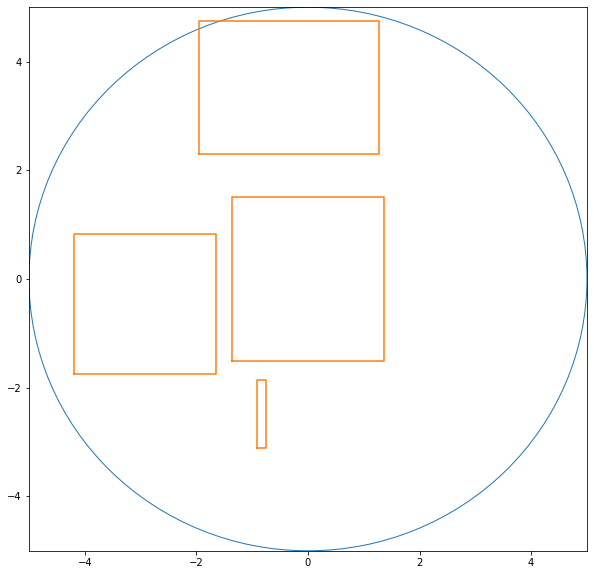

In [51]:
# Just for testing 
def fit_rects_in_circle_iteratively(rectangles: List[Rectangle], radius):
    rectangles = deepcopy(rectangles)
    not_drawn_items = rectangles
    drawn_rects = []
    forbidden_coords = set()
    blocked_coords = []
    layer_number = 1
    while not_drawn_items:
        drawn_rects_, not_drawn_items, blocked_coords_, forbidden_coords = fit_rectangles_in_circle(
            not_drawn_items, radius, forbidden_coords, layer_number
        )
        blocked_coords.extend(blocked_coords_)
        drawn_rects.extend(drawn_rects_)
        print(f"len(drawn_rects)={len(drawn_rects)}")
        layer_number += 1
    
    return drawn_rects, blocked_coords, forbidden_coords

random.seed(1)
max_r = 5

rects = [
    Rectangle(
        c=None,
        width = random.gauss(0, max_r/2),
        height = random.gauss(i, 1),
    )
    for i in range(1, 5)
]
print(rects)
drawn_rects, blocked_coords, forbidden_coords = fit_rects_in_circle_iteratively(rects, max_r)

shapes = [Circle(Pos(0, 0), max_r, layer_number=0)] + drawn_rects

draw(shapes, text_font_scale=10)

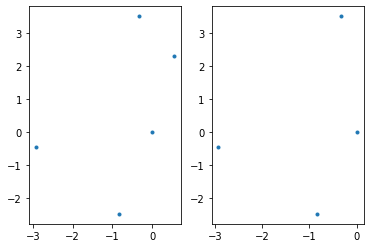

In [52]:
fig, ax = plt.subplots(1, 2)
bl = list(blocked_coords)
ax[0].plot([e.x for e in bl], [e.y for e in bl], '.')
fc = list(forbidden_coords)
ax[1].plot([e.x for e in fc], [e.y for e in fc], '.')